This cell loads the preprocessed stroke dataset and splits it into stratified train, validation, and test sets with a 60/20/20 ratio. Stratification maintains the class imbalance proportion across splits, which is important for consistent evaluation.

In [9]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, roc_auc_score, precision_recall_fscore_support)
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df = pd.read_csv("data/processed/stroke_processed.csv")

X = df.drop("stroke", axis=1)
y = df["stroke"]

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    stratify=y_temp,
    random_state=42
)


This cell standardizes the input features so the neural network trains more stably and efficiently. Class weights are computed to compensate for the strong class imbalance by penalizing mistakes on the minority (stroke) class more heavily.

In [2]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [3]:
classes = np.unique(y_train)
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weights = {cls: w for cls, w in zip(classes, class_weights_array)}
class_weights


{np.int64(0): np.float64(0.5255399382927666),
 np.int64(1): np.float64(10.288590604026846)}

This cell defines a shallow fully-connected neural network with two hidden layers (32 and 16 ReLU units) and a sigmoid output for binary classification. The architecture is intentionally small to reduce overfitting while still capturing non-linear relationships in the data.

In [4]:
input_dim = X_train_scaled.shape[1]

def build_shallow_nn(input_dim, dropout_rate=0.2):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid") 
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["Precision", "Recall"]
    )
    return model

nn_model = build_shallow_nn(input_dim)
nn_model.summary()


2025-12-07 18:56:50.878798: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,089 (4.25 KB)

 Trainable params: 1,089 (4.25 KB)

 Non-trainable params: 0 (0.00 B)

The model is trained with the Adam optimizer and binary cross-entropy loss, using early stopping to halt training when validation loss stops improving. Class weights are applied during training to mitigate the impact of class imbalance, and training time is recorded for later comparison.

In [10]:
batch_size = 64
epochs = 50

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

start = time.perf_counter()
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)
train_time_nn = time.perf_counter() - start

train_time_nn


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.1370 - Recall: 0.8591 - loss: 0.4432 - val_Precision: 0.1350 - val_Recall: 0.8400 - val_loss: 0.4676
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.1419 - Recall: 0.8255 - loss: 0.4486 - val_Precision: 0.1344 - val_Recall: 0.8200 - val_loss: 0.4649
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.1410 - Recall: 0.8591 - loss: 0.4356 - val_Precision: 0.1371 - val_Recall: 0.8200 - val_loss: 0.4488
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.1392 - Recall: 0.8456 - loss: 0.4391 - val_Precision: 0.1409 - val_Recall: 0.8200 - val_loss: 0.4357
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.1494 - Recall: 0.8725 - loss: 0.4321 - val_Precision: 0.1297 - val_Recall: 0.8200 - val_loss: 0.4808
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.1456 - Recall: 0.8792 - loss: 0.4298 - val_Precision: 0.1380 - val_Recall: 0.8200 - val_loss: 0.4434
Epoc

4.720307804644108

These plots show how training and validation loss, precision, and recall evolve over epochs. They are used to verify that the model is learning effectively and to check for signs of overfitting or underfitting.

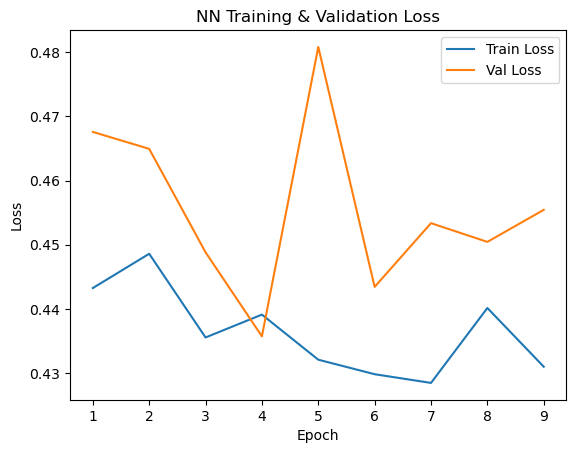

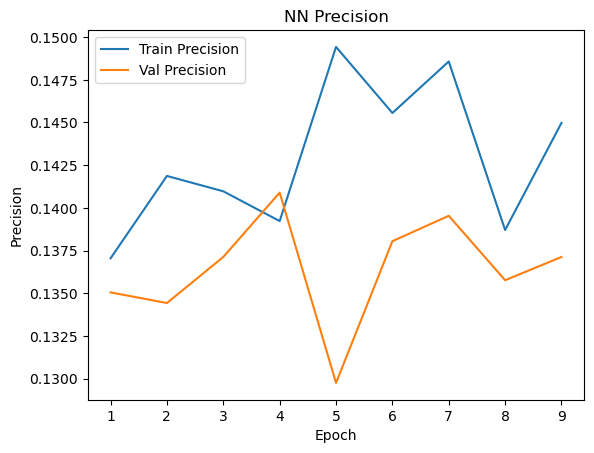

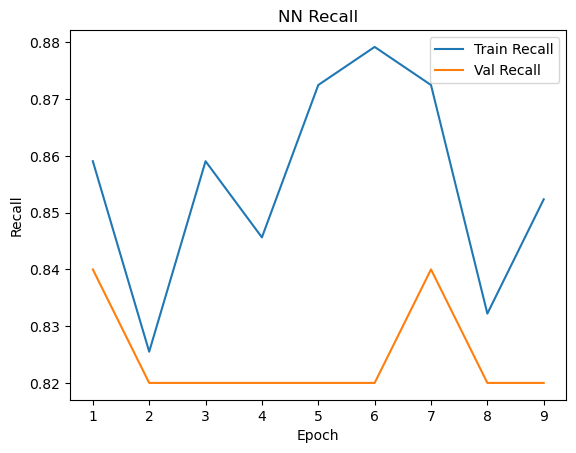

In [11]:
hist = history.history
epochs_range = range(1, len(hist["loss"]) + 1)

plt.figure()
plt.plot(epochs_range, hist["loss"], label="Train Loss")
plt.plot(epochs_range, hist["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("NN Training & Validation Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_range, hist["Precision"], label="Train Precision")
plt.plot(epochs_range, hist["val_Precision"], label="Val Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("NN Precision")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_range, hist["Recall"], label="Train Recall")
plt.plot(epochs_range, hist["val_Recall"], label="Val Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("NN Recall")
plt.legend()
plt.show()


This cell evaluates the neural network across several probability thresholds to examine the trade-off between precision, recall, and F1 score. A threshold of 0.50 turns out to give the highest F1, making it a good choice for final evaluation.

In [12]:
y_val_proba_nn = nn_model.predict(X_val_scaled).ravel()

for t in [0.50, 0.35, 0.30, 0.25, 0.20, 0.15, 0.10]:
    preds = (y_val_proba_nn >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_val, preds, average="binary", pos_label=1
    )
    print(f"t={t:.2f} | Precision={precision:.3f}  Recall={recall:.3f}  F1={f1:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
t=0.50 | Precision=0.141  Recall=0.820  F1=0.240
t=0.35 | Precision=0.119  Recall=0.900  F1=0.210
t=0.30 | Precision=0.113  Recall=0.900  F1=0.201
t=0.25 | Precision=0.105  Recall=0.920  F1=0.188
t=0.20 | Precision=0.096  Recall=0.940  F1=0.174
t=0.15 | Precision=0.088  Recall=0.960  F1=0.161
t=0.10 | Precision=0.081  Recall=1.000  F1=0.149


In [13]:
import os

# Choose the best threshold from the sweep
threshold_nn = 0.50

start = time.perf_counter()
y_val_proba_nn = nn_model.predict(X_val_scaled).ravel()
inference_time_nn = time.perf_counter() - start

y_val_pred_nn = (y_val_proba_nn >= threshold_nn).astype(int)

print(f"Shallow NN (Validation) with threshold = {threshold_nn}")
print(classification_report(y_val, y_val_pred_nn, digits=4, zero_division=0))

precision_nn, recall_nn, f1_nn, _ = precision_recall_fscore_support(
    y_val, y_val_pred_nn, average="binary", pos_label=1
)
roc_auc_nn = roc_auc_score(y_val, y_val_proba_nn)
print("Validation ROC-AUC (NN):", roc_auc_nn)

# Save metrics
os.makedirs("results", exist_ok=True)

nn_results_df = pd.DataFrame([{
    "Model": "Shallow Neural Network",
    "Train_time": train_time_nn,
    "Inference_time": inference_time_nn,
    "Precision": precision_nn,
    "Recall": recall_nn,
    "F1": f1_nn,
    "ROC_AUC": roc_auc_nn
}])

nn_results_df.to_csv("results/nn_metrics.csv", index=False)
nn_results_df



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Shallow NN (Validation) with threshold = 0.5
              precision    recall  f1-score   support

           0     0.9877    0.7428    0.8479       972
           1     0.1409    0.8200    0.2405        50

    accuracy                         0.7466      1022
   macro avg     0.5643    0.7814    0.5442      1022
weighted avg     0.9463    0.7466    0.8182      1022

Validation ROC-AUC (NN): 0.834156378600823


,Model,Train_time,Inference_time,Precision,Recall,F1,ROC_AUC
0,Shallow Neural Network,4.720308,0.285983,0.140893,0.82,0.240469,0.834156
